In [1]:
%load_ext autoreload
%autoreload 2

# Create circuit

This section serves as an introductory guide to the use of qWard. It presents a code example that aims to construct a Bell state circuit and executes it through the Qiskit AER simulator. In summary, the guide addresses the configuration of the calculation part and the display of visualization results.

This section describes the creation of a \textit{Scanner} instance, the integration of particular metrics strategies, the acquisition of results in the form of Pandas DataFrames, and the visualization of these results.

The first step involves the creation of the 2-qubit Bell state circuit as listed below:

In [2]:
from qiskit import QuantumCircuit


def create_circuit():
    circuit = QuantumCircuit(2, 2)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.measure([0, 1], [0, 1])
    display(circuit.draw(output="mpl"))

    return circuit

# AER simulators

Now, we need to configure the Qiskit AER simulator as shown in the following cells

In [3]:
from qiskit_aer import AerSimulator, AerJob
from qiskit_aer.noise import (
    NoiseModel,
    ReadoutError,
    pauli_error,
    depolarizing_error,
)

In [4]:
def run_simulators(circuit):
    # ****** no noise ******
    no_noise = AerSimulator()

    # ****** noise model with depolarizing errors ******
    noise_model1 = NoiseModel()

    # Add depolarizing error to all single qubit gates
    depol_error = depolarizing_error(0.05, 1)  # 5% depolarizing error
    noise_model1.add_all_qubit_quantum_error(depol_error, ["u1", "u2", "u3"])

    # Add depolarizing error to all two qubit gates
    depol_error_2q = depolarizing_error(0.1, 2)  # 10% depolarizing error
    noise_model1.add_all_qubit_quantum_error(depol_error_2q, ["cx"])

    # Add readout error
    readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])  # 10% readout error
    noise_model1.add_all_qubit_readout_error(readout_error)

    # Create a simulator with the first noise model
    depolarizing_errors = AerSimulator(noise_model=noise_model1)

    # ****** noise model with Pauli errors ******
    noise_model2 = NoiseModel()

    # Add Pauli error to all single qubit gates
    pauli_error_1q = pauli_error([("X", 0.05), ("Y", 0.05), ("Z", 0.05), ("I", 0.85)])
    noise_model2.add_all_qubit_quantum_error(pauli_error_1q, ["u1", "u2", "u3"])

    # Add Pauli error to all two qubit gates
    pauli_error_2q = pauli_error([("XX", 0.05), ("YY", 0.05), ("ZZ", 0.05), ("II", 0.85)])
    noise_model2.add_all_qubit_quantum_error(pauli_error_2q, ["cx"])

    # Add readout error
    readout_error = ReadoutError([[0.95, 0.05], [0.05, 0.95]])  # 5% readout error
    noise_model2.add_all_qubit_readout_error(readout_error)

    # Create a simulator with the second noise model
    pauli_errors = AerSimulator(noise_model=noise_model2)

    jobs = [
        no_noise.run(circuit, shots=1024),
        depolarizing_errors.run(circuit, shots=1024),
        pauli_errors.run(circuit, shots=1024),
    ]

    return {
        "jobs": jobs,
        "circuits": [circuit, circuit, circuit],
        "backends": [no_noise, depolarizing_errors, pauli_errors],
    }

# IBM backend

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit.transpiler import generate_preset_pass_manager
import time

In [6]:
IBM_QUANTUM_CHANNEL = "ibm_cloud"
IBM_QUANTUM_TOKEN = "xxxxxxxxxx"

In [7]:
QiskitRuntimeService.save_account(
    channel=IBM_QUANTUM_CHANNEL, token=IBM_QUANTUM_TOKEN, overwrite=True, instance="thecap"
)

In [8]:
def run_ibm(circuit):
    service = QiskitRuntimeService()
    backends = service.backends(instance="thecap")
    backend = min(backends, key=lambda b: b.status().pending_jobs)
    print(f">>> Backend name: {backend.name}")
    print(f">>> Backend status: {backend.status()}")
    print(f">>> Backend configuration: {backend.configuration()}")

    batch = Batch(backend=backend)
    print(f">>> Batch ID: {batch.session_id}")

    pass_manager_0 = generate_preset_pass_manager(
        optimization_level=0,
        backend=backend,
    )
    pass_manager_1 = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        routing_method="sabre",
    )
    pass_manager_2 = generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        layout_method="dense",
        routing_method="lookahead",
    )

    with batch:
        sampler = Sampler()
        isa_circuit_0 = pass_manager_0.run(circuit)
        isa_circuit_1 = pass_manager_1.run(circuit)
        isa_circuit_2 = pass_manager_2.run(circuit)
        job_0 = sampler.run([isa_circuit_0])
        job_1 = sampler.run([isa_circuit_1])
        job_2 = sampler.run([isa_circuit_2])

    start_time = time.time()

    while time.time() - start_time < 600:  # 10 minutes
        status = batch.status()
        print(f">>> Batch Status: {status}")

        # Print individual job statuses
        print(f">>> Job 0 (Opt Level 0) Status: {job_0.status()}")
        print(f">>> Job 1 (Opt Level 2) Status: {job_1.status()}")
        print(f">>> Job 2 (Opt Level 3) Status: {job_2.status()}")

        # Check if all jobs are completed
        if all(job.status() in ["DONE", "CANCELLED", "ERROR"] for job in [job_0, job_1, job_2]):
            print(">>> All jobs completed!")
            break

        time.sleep(10)  # Wait 10 seconds before checking again

    # Close the batch
    batch.close()
    print(f">>> Batch {batch.session_id} closed")

    # Print job results
    try:
        print("\n>>> Job Results:")
        print(f"Job 0 (Optimization Level 0): {job_0.result()}")
        print(f"Job 1 (Optimization Level 2): {job_1.result()}")
        print(f"Job 2 (Optimization Level 3): {job_2.result()}")

        # Print circuit depths for comparison
        print(f"\n>>> Circuit Depths:")
        print(f"Original circuit depth: {circuit.depth()}")
        print(f"Optimized circuit 0 depth: {isa_circuit_0.depth()}")
        print(f"Optimized circuit 1 depth: {isa_circuit_1.depth()}")
        print(f"Optimized circuit 2 depth: {isa_circuit_2.depth()}")

    except Exception as e:
        print(f">>> Error retrieving results: {e}")

    return {
        "batch_id": batch.session_id,
        "jobs": [job_0, job_1, job_2],
        "circuits": [isa_circuit_0, isa_circuit_1, isa_circuit_2],
    }

# qWard in action

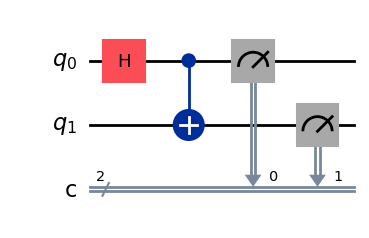

In [9]:
from qward import Scanner
from qward.metrics import QiskitMetrics, ComplexityMetrics, CircuitPerformanceMetrics
import json

circuit = create_circuit()
simulators_results = run_simulators(circuit)

In [ ]:
ibm_results = run_ibm(circuit)

In [10]:
def get_jobs_from_batch(batch_id):
    """
    Extract jobs from a batch object in different ways
    """

    # Method 1: Get jobs directly from the service using session_id
    service = QiskitRuntimeService(
        channel=IBM_QUANTUM_CHANNEL, instance="thecap", token=IBM_QUANTUM_TOKEN
    )

    # Get all jobs from this batch/session
    batch_jobs = service.jobs(session_id=batch_id, limit=100)
    print(f">>> Found {len(batch_jobs)} jobs in this batch")

    # Display job information
    for i, job in enumerate(batch_jobs):
        print(f"    Job {i}: {job.job_id()}")
        print(f"        Status: {job.status()}")
        print(f"        Creation Date: {job.creation_date}")

        # Get results if job is completed
        if job.status() == "DONE":
            try:
                result = job.result()
                print(f"        Result: {result}")
            except Exception as e:
                print(f"        Error getting result: {e}")

    return batch_jobs

In [11]:
ibm_jobs = get_jobs_from_batch("1036066f-3ce7-4d02-b2ff-a83bffc02735")

>>> Found 3 jobs in this batch
    Job 0: d365f0kda4cs73a7ifug
        Status: DONE
        Creation Date: 2025-09-18 19:03:30.166273+00:00
        Result: PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-09-18 19:22:52', stop='2025-09-18 19:22:54', size=4096>)])}, 'version': 2})
    Job 1: d365f0cda4cs73a7ifu0
        Status: DONE
        Creation Date: 2025-09-18 19:03:29.695703+00:00
        Result: PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-09-18 19:22:50', stop='2025-09-18 19:22:52', size=4096>)])}, 'version': 2})
    Job 2: d365f080sqis7397bj80
        Status: DONE
        Creation Date: 2025-09-18 19:03:29.234836+00:00
        

In [12]:
# define metrics
def bell_success_criteria(result: str) -> bool:
    # Remove spaces to get clean bit string
    clean_result = result.replace(" ", "")
    # For Bell states, we expect either all 0s or all 1s
    return clean_result in ["00", "11"]


def expected_distribution():
    # For Bell states, we expect either all 0s or all 1s
    return {"00": 0.5, "11": 0.5}


bell_success = CircuitPerformanceMetrics(
    circuit,
    jobs=simulators_results["jobs"],
    success_criteria=bell_success_criteria,
    expected_distribution=expected_distribution(),
)

# Create a scanner with the circuit
scanner = Scanner(
    circuit=circuit,
    strategies=[
        bell_success,
        QiskitMetrics,
        ComplexityMetrics,
    ],
)

metrics_dict = scanner.calculate_metrics()

# Display summary using Scanner method
scanner.display_summary(metrics_dict)

# Display raw DataFrames for detailed analysis
print("\n" + "=" * 80)
print("📊 DETAILED METRICS DATA")
print("=" * 80)
for metric_name, metric_df in metrics_dict.items():
    print(f"\n=== {metric_name} ===")
    display(metric_df)


🎯 QWARD ANALYSIS SUMMARY

📋 Circuit Performance Analysis:
   Jobs analyzed: 3
   Job 1: 100.0% success, 1.000 fidelity (1024 shots)
   Job 2: 80.1% success, 0.895 fidelity (1024 shots)
   Job 3: 88.5% success, 0.941 fidelity (1024 shots)

📊 Overall Performance:
   Average success rate: 89.5% ± 8.2%
   Total measurements: 3072
   ⚠️  Good performance with some noise impact

📈 Additional Metrics:
   QiskitMetrics: 25 metrics calculated
     Preview (first 5):
       basic_metrics.depth: 3
       basic_metrics.width: 4
       basic_metrics.size: 4
       basic_metrics.num_qubits: 2
       basic_metrics.num_clbits: 2
       ... and 20 more metrics
   ComplexityMetrics: 19 metrics calculated
     Preview (first 5):
       gate_based_metrics.gate_count: 4.0
       gate_based_metrics.circuit_depth: 3.0
       gate_based_metrics.t_count: 0.0
       gate_based_metrics.cnot_count: 1.0
       gate_based_metrics.two_qubit_count: 1.0
       ... and 14 more metrics

📊 DETAILED METRICS DATA

=== Cir

,success_metrics.error_rate,success_metrics.mean_success_rate,success_metrics.std_success_rate,success_metrics.min_success_rate,success_metrics.max_success_rate,success_metrics.total_trials,fidelity_metrics.method,fidelity_metrics.confidence,fidelity_metrics.mean_fidelity,fidelity_metrics.std_fidelity,fidelity_metrics.min_fidelity,fidelity_metrics.max_fidelity,statistical_metrics.mean_entropy,statistical_metrics.mean_uniformity,statistical_metrics.mean_concentration,statistical_metrics.mean_dominant_probability,statistical_metrics.std_entropy,statistical_metrics.std_uniformity
0,0.104818,0.895182,0.081664,0.800781,1.0,3072,theoretical_comparison,high,0.94504,0.043153,0.89457,0.999988,1.411197,0.872254,0.127746,0.45931,0.302503,0.099425



=== CircuitPerformance.individual_jobs ===


,success_metrics.success_rate,success_metrics.error_rate,success_metrics.total_shots,success_metrics.successful_shots,fidelity_metrics.fidelity,fidelity_metrics.has_expected_distribution,fidelity_metrics.method,fidelity_metrics.confidence,statistical_metrics.entropy,statistical_metrics.uniformity,statistical_metrics.concentration,statistical_metrics.dominant_outcome_probability,statistical_metrics.num_unique_outcomes
0,1.000000,0.000000,1024,1024,0.999988,True,theoretical_comparison,high,0.999931,0.999931,0.000069,0.504883,2
1,0.800781,0.199219,1024,820,0.894570,True,theoretical_comparison,high,1.718847,0.859423,0.140577,0.420898,4
2,0.884766,0.115234,1024,906,0.940563,True,theoretical_comparison,high,1.514812,0.757406,0.242594,0.452148,4



=== QiskitMetrics ===


,basic_metrics.depth,basic_metrics.width,basic_metrics.size,basic_metrics.num_qubits,basic_metrics.num_clbits,basic_metrics.num_ancillas,basic_metrics.num_parameters,basic_metrics.has_calibrations,basic_metrics.has_layout,basic_metrics.count_ops.measure,...,instruction_metrics.num_unitary_factors,instruction_metrics.instructions.measure,instruction_metrics.instructions.h,instruction_metrics.instructions.cx,scheduling_metrics.is_scheduled,scheduling_metrics.layout,scheduling_metrics.op_start_times,scheduling_metrics.qubit_duration,scheduling_metrics.qubit_start_time,scheduling_metrics.qubit_stop_time
0,3,4,4,2,2,0,0,False,False,2,...,1,"[(Instruction(name='measure', num_qubits=1, nu...","[(Instruction(name='h', num_qubits=1, num_clbi...","[(Instruction(name='cx', num_qubits=2, num_clb...",False,None,None,None,None,None



=== ComplexityMetrics ===


,gate_based_metrics.gate_count,gate_based_metrics.circuit_depth,gate_based_metrics.t_count,gate_based_metrics.cnot_count,gate_based_metrics.two_qubit_count,gate_based_metrics.multi_qubit_ratio,entanglement_metrics.entangling_gate_density,entanglement_metrics.entangling_width,standardized_metrics.circuit_volume,standardized_metrics.gate_density,standardized_metrics.clifford_ratio,standardized_metrics.non_clifford_ratio,advanced_metrics.parallelism_factor,advanced_metrics.parallelism_efficiency,advanced_metrics.circuit_efficiency,advanced_metrics.quantum_resource_utilization,derived_metrics.square_ratio,derived_metrics.weighted_complexity,derived_metrics.normalized_weighted_complexity
0,4,3,0,1,1,0.25,0.25,2,6,0.667,1.0,0.0,1.333,0.667,0.667,0.722,0.667,21,10.5


## Visualization

In [13]:
from qward.visualization.constants import Metrics, Plots
from qward.visualization import PlotConfig, IEEEPlotConfig
from qward import Visualizer

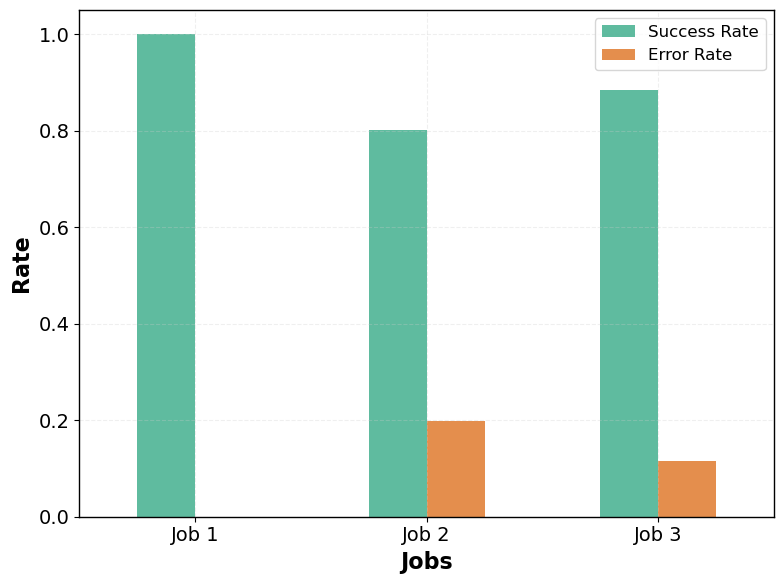

In [14]:
ieee_config = IEEEPlotConfig(show_titles=False)
visualizer = Visualizer(scanner=scanner, config=ieee_config, output_dir="img/bell_state_simulation")

error_plot = visualizer.generate_plot(
    metric_name=Metrics.CIRCUIT_PERFORMANCE,
    plot_name=Plots.CircuitPerformance.SUCCESS_ERROR_COMPARISON,
    save=True,
    show=True,
)

error_plot.show()

Creating dashboard for metrics: CircuitPerformance, QiskitMetrics, ComplexityMetrics


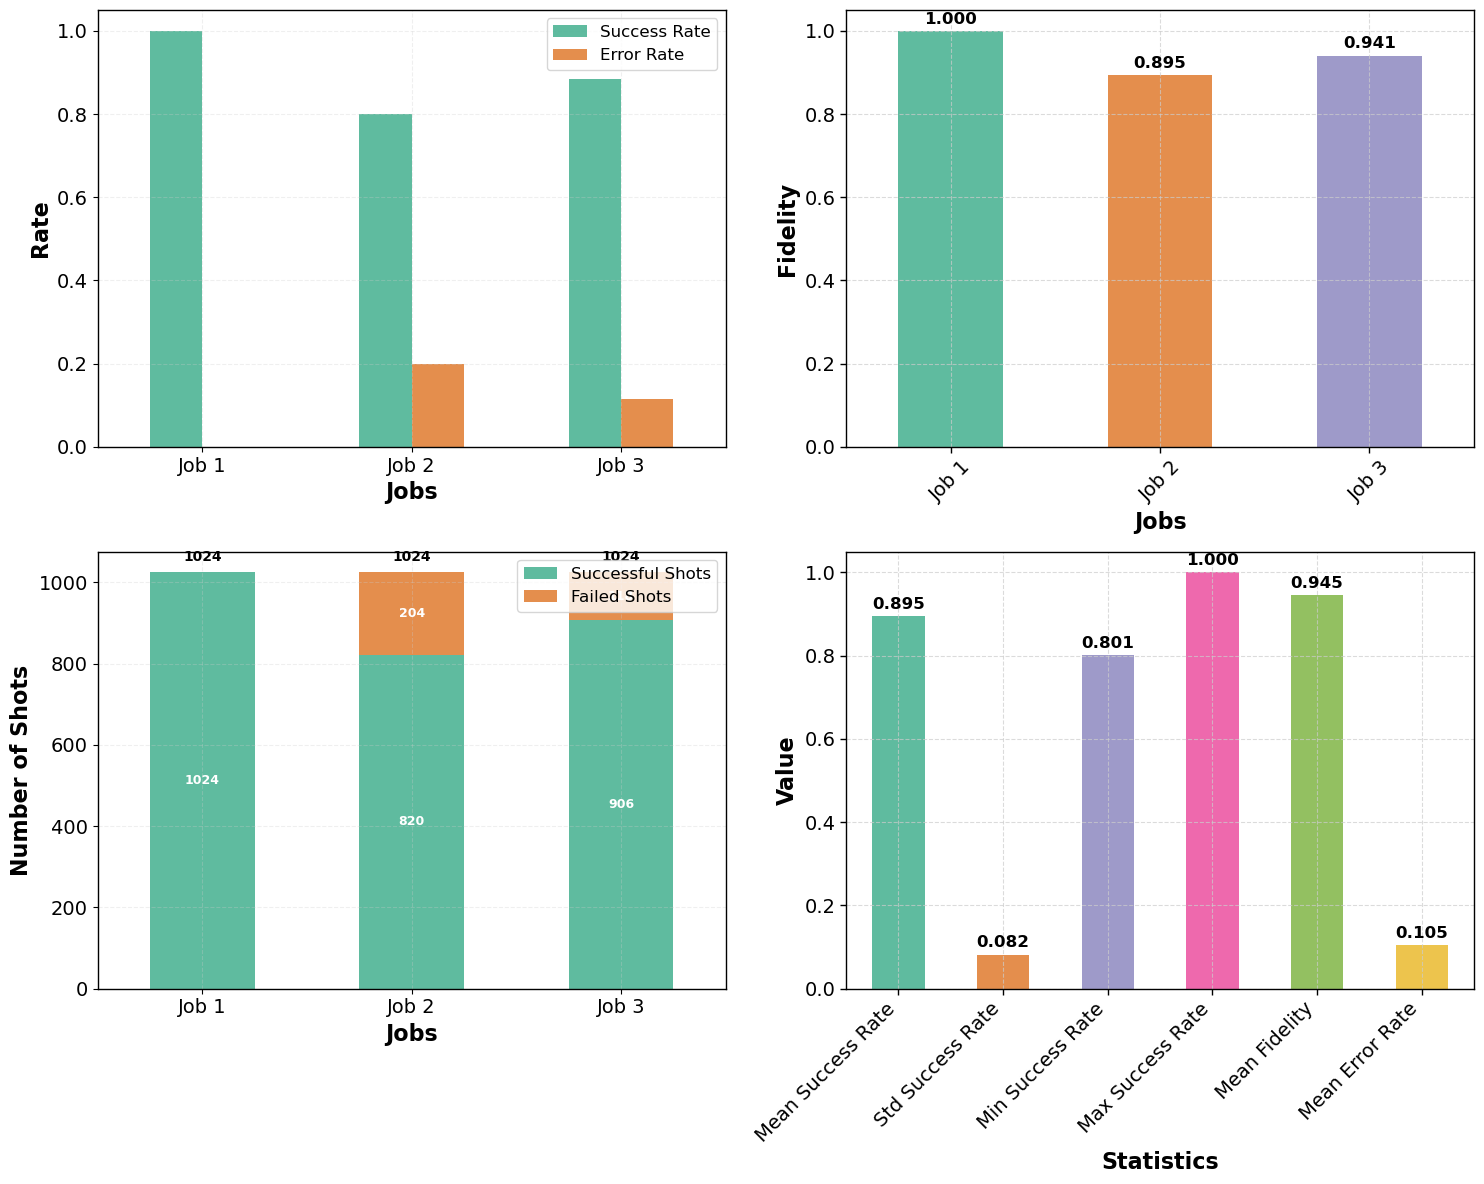

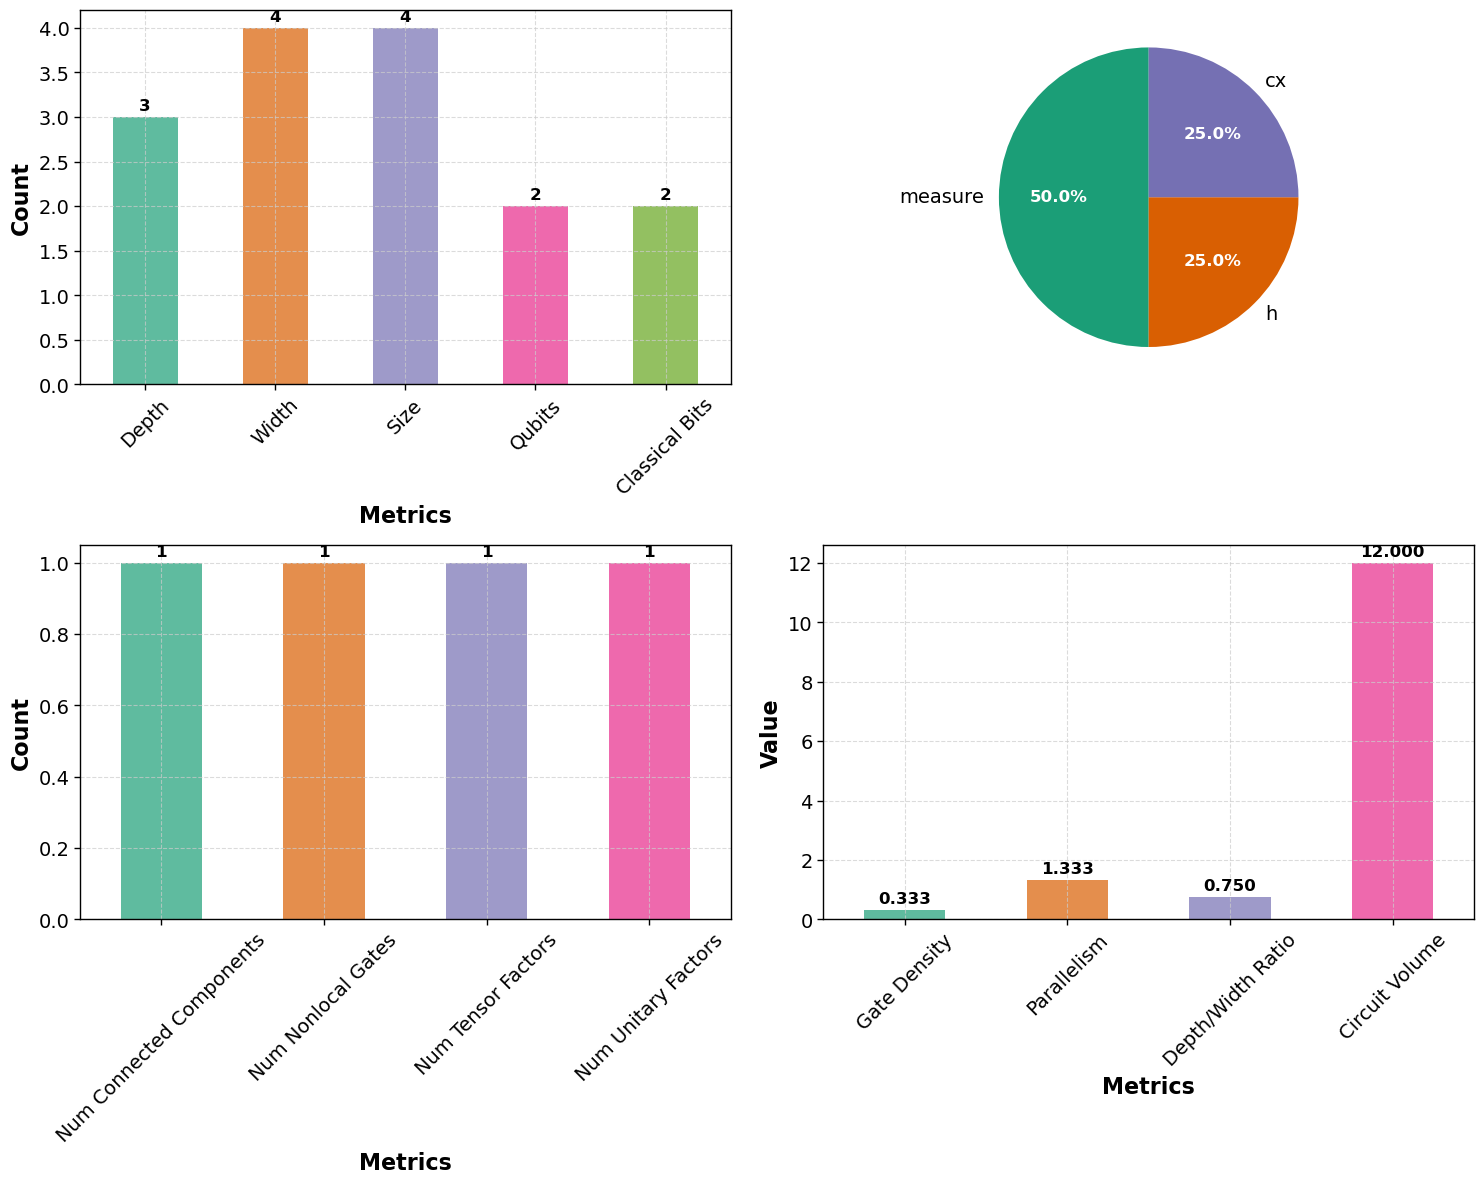

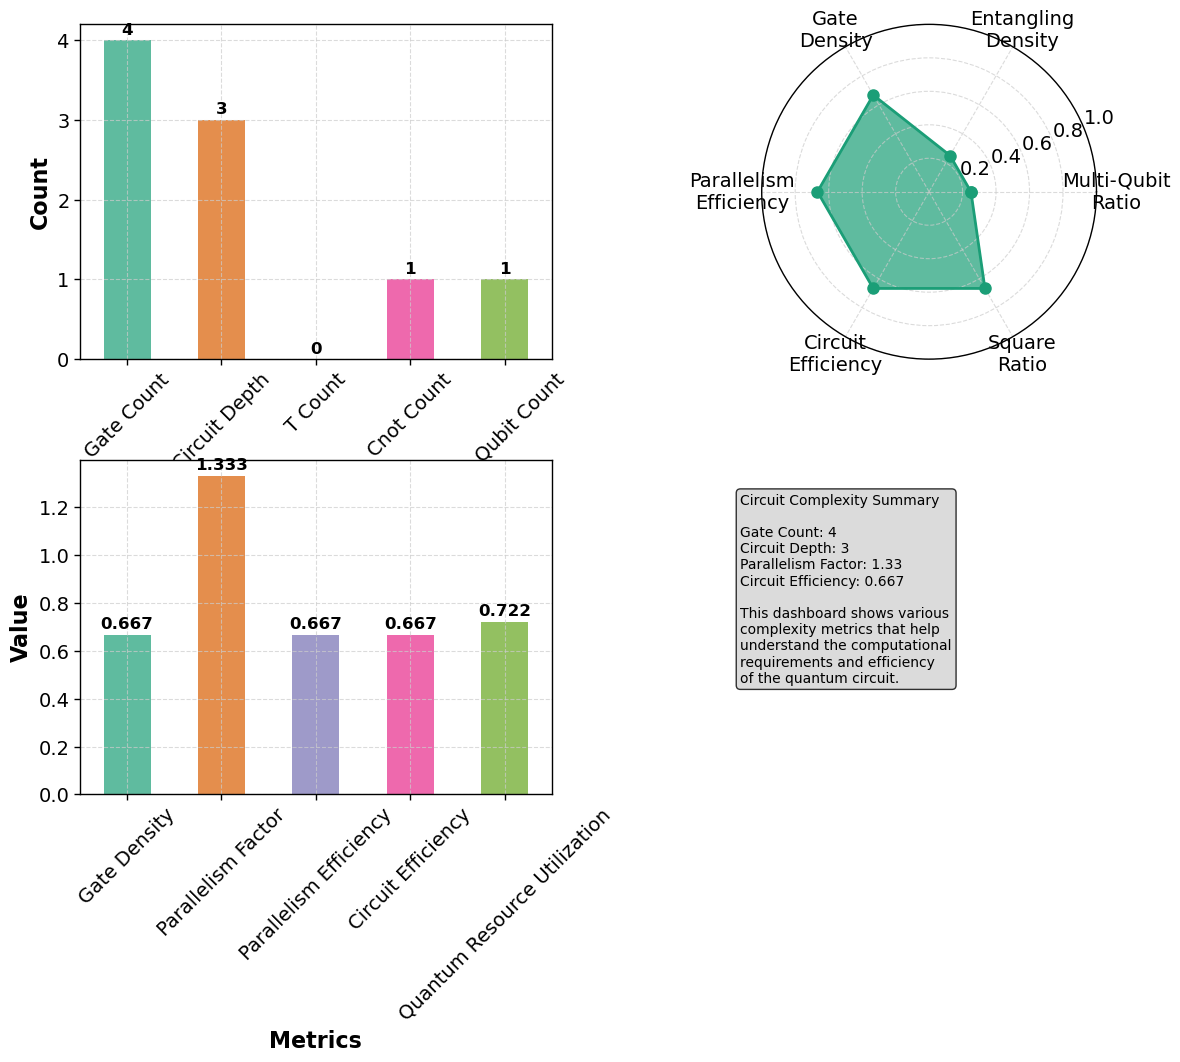

In [15]:
dashboard = visualizer.create_dashboard(save=True, show=True)

### IBM on qWard 

In [16]:
# define metrics
def bell_success_criteria(result: str) -> bool:
    # Remove spaces to get clean bit string
    clean_result = result.replace(" ", "")
    # For Bell states, we expect either all 0s or all 1s
    return clean_result in ["00", "11"]


def expected_distribution():
    # For Bell states, we expect either all 0s or all 1s
    return {"00": 0.5, "11": 0.5}


bell_success = CircuitPerformanceMetrics(
    circuit,
    jobs=ibm_jobs,
    success_criteria=bell_success_criteria,
    expected_distribution=expected_distribution(),
)

# Create a scanner with the circuit
scanner = Scanner(
    circuit=circuit,
    strategies=[
        bell_success,
        QiskitMetrics,
        ComplexityMetrics,
    ],
)

metrics_dict = scanner.calculate_metrics()

# Display summary using Scanner method
scanner.display_summary(metrics_dict)

# Display raw DataFrames for detailed analysis
print("\n" + "=" * 80)
print("📊 DETAILED METRICS DATA")
print("=" * 80)
for metric_name, metric_df in metrics_dict.items():
    print(f"\n=== {metric_name} ===")
    display(metric_df)


🎯 QWARD ANALYSIS SUMMARY

📋 Circuit Performance Analysis:
   Jobs analyzed: 3
   Job 1: 94.5% success, 0.971 fidelity (4096 shots)
   Job 2: 94.5% success, 0.971 fidelity (4096 shots)
   Job 3: 86.1% success, 0.927 fidelity (4096 shots)

📊 Overall Performance:
   Average success rate: 91.7% ± 4.0%
   Total measurements: 12288
   ⚠️  Good performance with some noise impact

📈 Additional Metrics:
   QiskitMetrics: 25 metrics calculated
     Preview (first 5):
       basic_metrics.depth: 3
       basic_metrics.width: 4
       basic_metrics.size: 4
       basic_metrics.num_qubits: 2
       basic_metrics.num_clbits: 2
       ... and 20 more metrics
   ComplexityMetrics: 19 metrics calculated
     Preview (first 5):
       gate_based_metrics.gate_count: 4.0
       gate_based_metrics.circuit_depth: 3.0
       gate_based_metrics.t_count: 0.0
       gate_based_metrics.cnot_count: 1.0
       gate_based_metrics.two_qubit_count: 1.0
       ... and 14 more metrics

📊 DETAILED METRICS DATA

=== Cir

,success_metrics.error_rate,success_metrics.mean_success_rate,success_metrics.std_success_rate,success_metrics.min_success_rate,success_metrics.max_success_rate,success_metrics.total_trials,fidelity_metrics.method,fidelity_metrics.confidence,fidelity_metrics.mean_fidelity,fidelity_metrics.std_fidelity,fidelity_metrics.min_fidelity,fidelity_metrics.max_fidelity,statistical_metrics.mean_entropy,statistical_metrics.mean_uniformity,statistical_metrics.mean_concentration,statistical_metrics.mean_dominant_probability,statistical_metrics.std_entropy,statistical_metrics.std_uniformity
0,0.083252,0.916748,0.039706,0.860596,0.945068,12288,theoretical_comparison,high,0.956404,0.020958,0.926766,0.97141,1.393451,0.696726,0.303274,0.496582,0.128448,0.064224



=== CircuitPerformance.individual_jobs ===


,success_metrics.success_rate,success_metrics.error_rate,success_metrics.total_shots,success_metrics.successful_shots,fidelity_metrics.fidelity,fidelity_metrics.has_expected_distribution,fidelity_metrics.method,fidelity_metrics.confidence,statistical_metrics.entropy,statistical_metrics.uniformity,statistical_metrics.concentration,statistical_metrics.dominant_outcome_probability,statistical_metrics.num_unique_outcomes
0,0.944580,0.055420,4096,3869,0.971036,True,theoretical_comparison,high,1.304137,0.652069,0.347931,0.511963,4
1,0.945068,0.054932,4096,3871,0.971410,True,theoretical_comparison,high,1.301120,0.650560,0.349440,0.509277,4
2,0.860596,0.139404,4096,3525,0.926766,True,theoretical_comparison,high,1.575096,0.787548,0.212452,0.468506,4



=== QiskitMetrics ===


,basic_metrics.depth,basic_metrics.width,basic_metrics.size,basic_metrics.num_qubits,basic_metrics.num_clbits,basic_metrics.num_ancillas,basic_metrics.num_parameters,basic_metrics.has_calibrations,basic_metrics.has_layout,basic_metrics.count_ops.measure,...,instruction_metrics.num_unitary_factors,instruction_metrics.instructions.measure,instruction_metrics.instructions.h,instruction_metrics.instructions.cx,scheduling_metrics.is_scheduled,scheduling_metrics.layout,scheduling_metrics.op_start_times,scheduling_metrics.qubit_duration,scheduling_metrics.qubit_start_time,scheduling_metrics.qubit_stop_time
0,3,4,4,2,2,0,0,False,False,2,...,1,"[(Instruction(name='measure', num_qubits=1, nu...","[(Instruction(name='h', num_qubits=1, num_clbi...","[(Instruction(name='cx', num_qubits=2, num_clb...",False,None,None,None,None,None



=== ComplexityMetrics ===


,gate_based_metrics.gate_count,gate_based_metrics.circuit_depth,gate_based_metrics.t_count,gate_based_metrics.cnot_count,gate_based_metrics.two_qubit_count,gate_based_metrics.multi_qubit_ratio,entanglement_metrics.entangling_gate_density,entanglement_metrics.entangling_width,standardized_metrics.circuit_volume,standardized_metrics.gate_density,standardized_metrics.clifford_ratio,standardized_metrics.non_clifford_ratio,advanced_metrics.parallelism_factor,advanced_metrics.parallelism_efficiency,advanced_metrics.circuit_efficiency,advanced_metrics.quantum_resource_utilization,derived_metrics.square_ratio,derived_metrics.weighted_complexity,derived_metrics.normalized_weighted_complexity
0,4,3,0,1,1,0.25,0.25,2,6,0.667,1.0,0.0,1.333,0.667,0.667,0.722,0.667,21,10.5


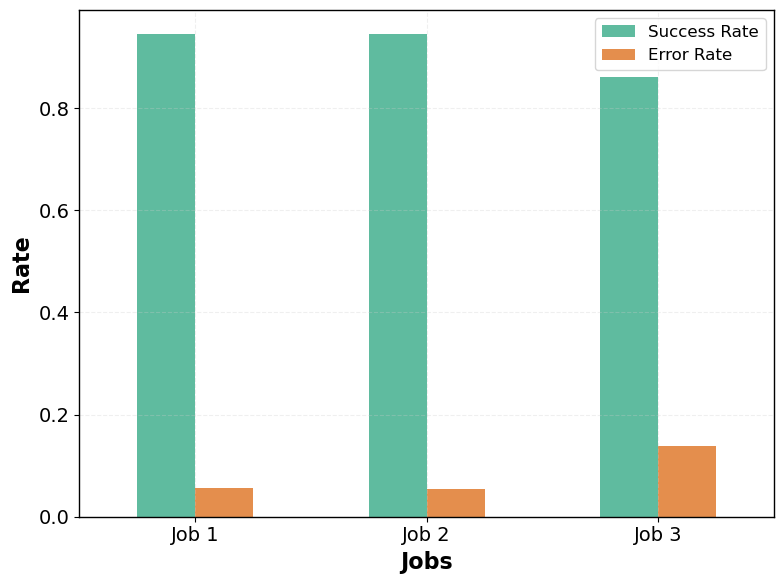

In [17]:
from qward.visualization.constants import Metrics, Plots
from qward.visualization import PlotConfig, IEEEPlotConfig
from qward import Visualizer

ieee_config = IEEEPlotConfig(show_titles=False)
visualizer = Visualizer(scanner=scanner, config=ieee_config, output_dir="img/bell_state_ibm")

error_plot = visualizer.generate_plot(
    metric_name=Metrics.CIRCUIT_PERFORMANCE,
    plot_name=Plots.CircuitPerformance.SUCCESS_ERROR_COMPARISON,
    save=True,
    show=True,
)

error_plot.show()

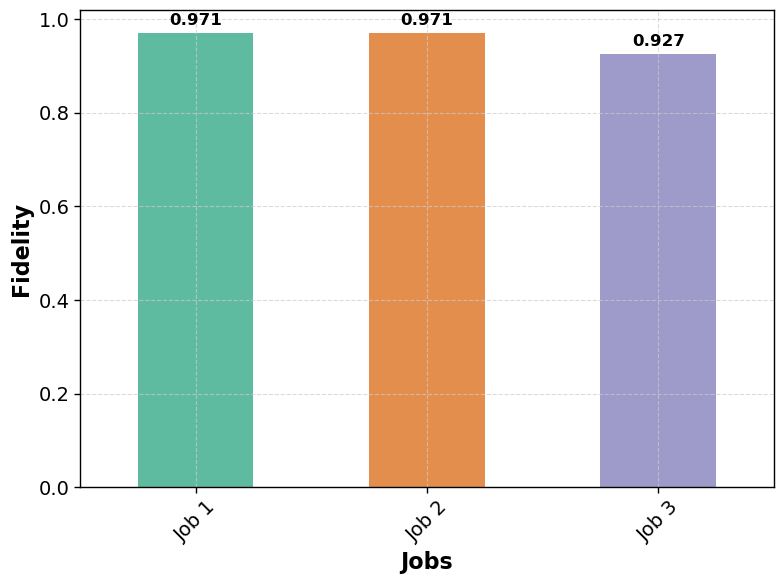

In [18]:
error_plot = visualizer.generate_plot(
    metric_name=Metrics.CIRCUIT_PERFORMANCE,
    plot_name=Plots.CircuitPerformance.FIDELITY_COMPARISON,
    save=True,
    show=True,
)

Creating dashboard for metrics: CircuitPerformance, QiskitMetrics, ComplexityMetrics


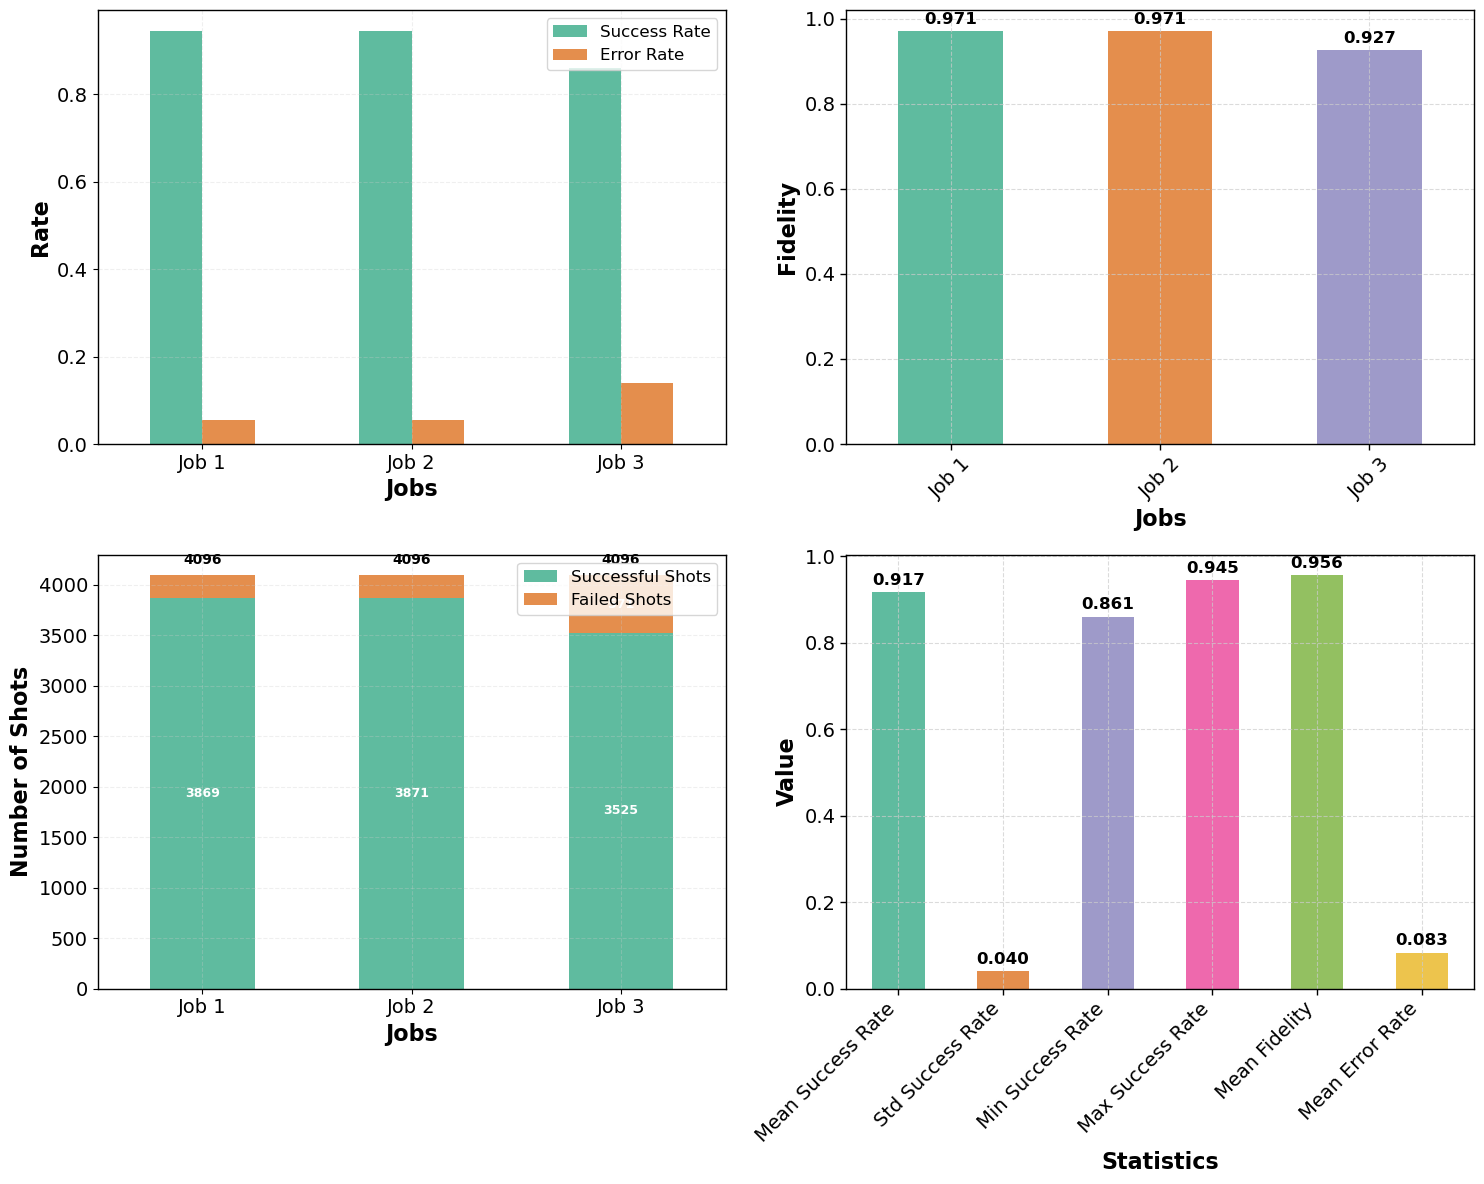

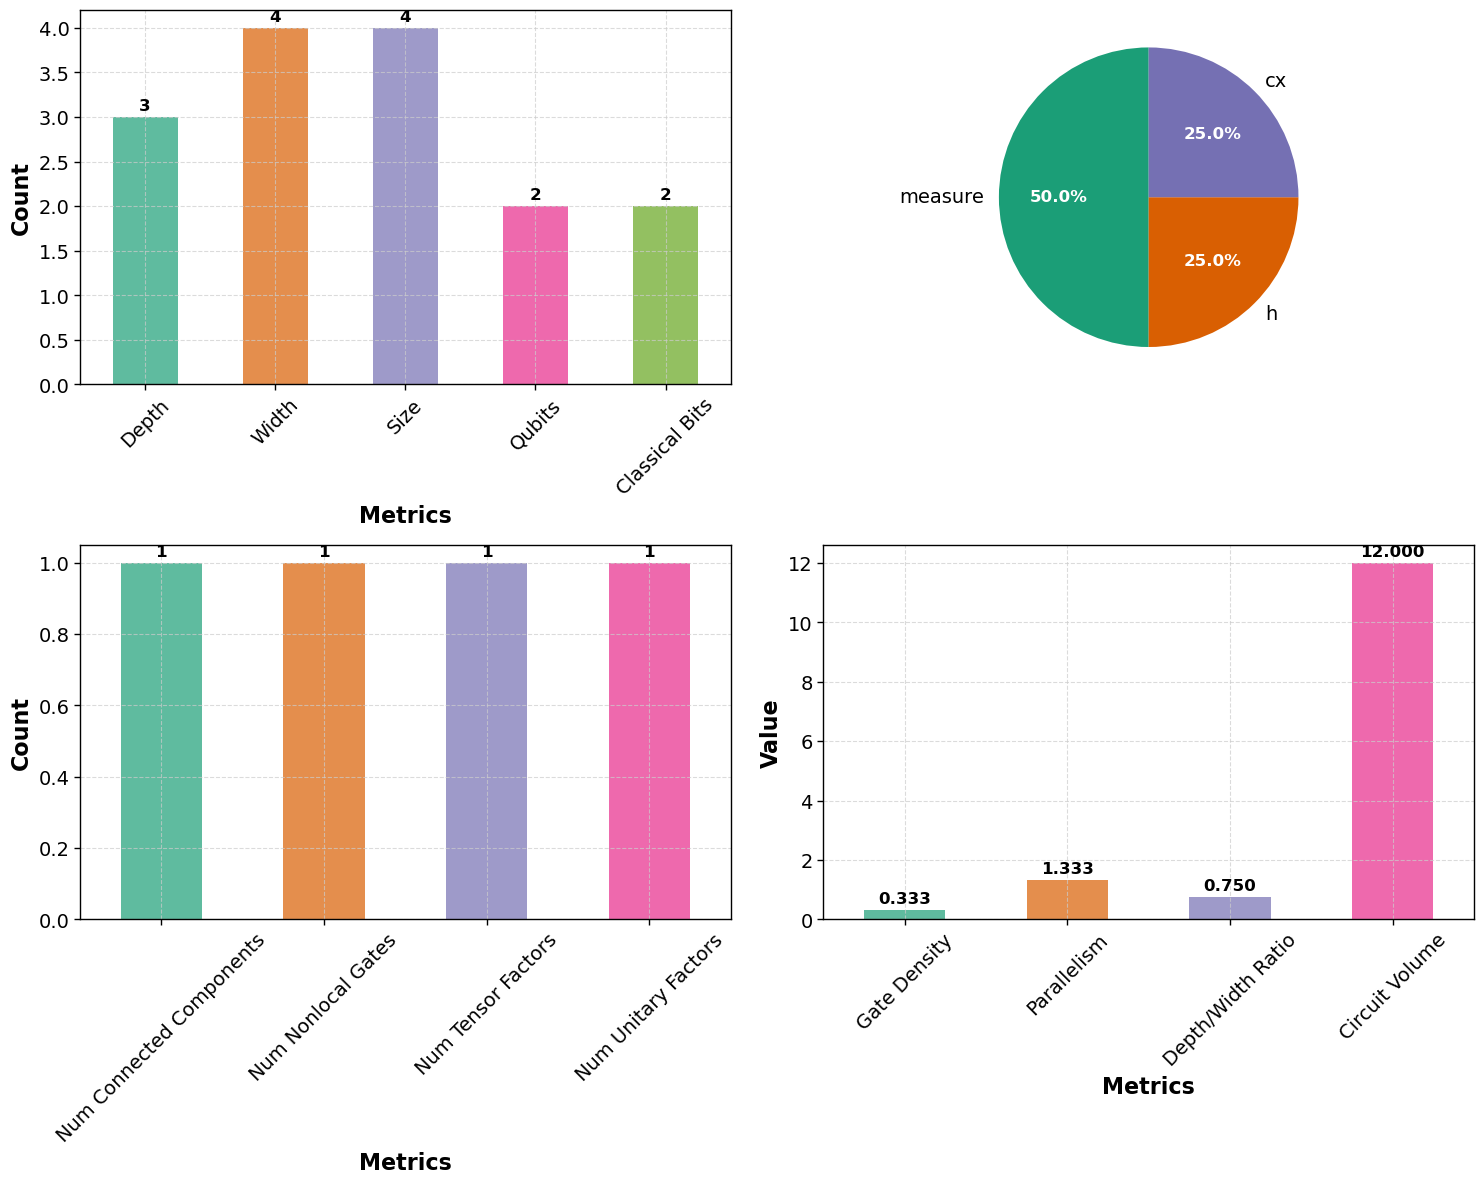

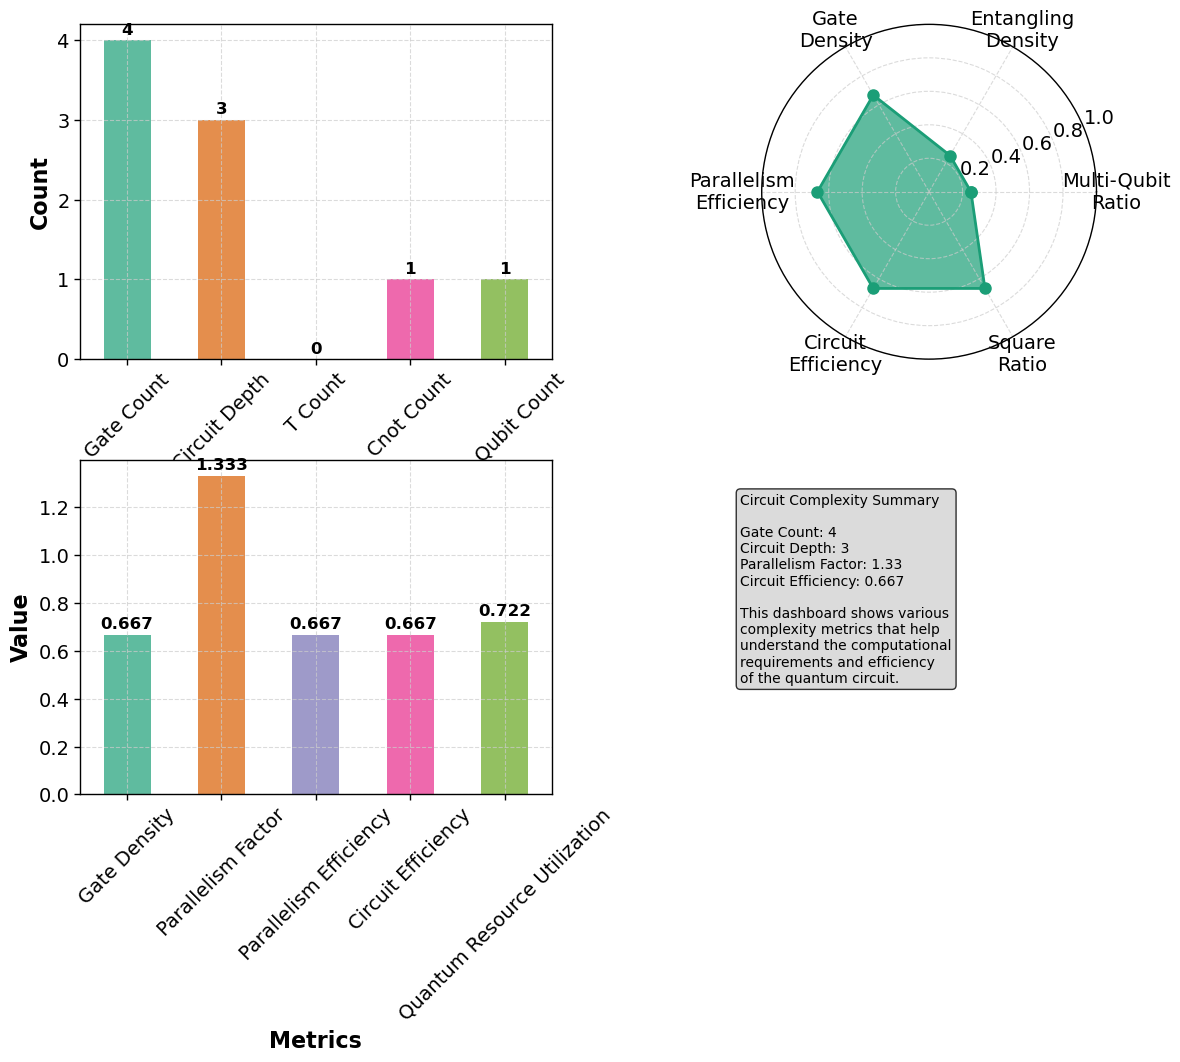

In [19]:
dashboard = visualizer.create_dashboard(save=True, show=True)

{'CircuitPerformance': {'success_error_comparison': <Figure size 800x600 with 1 Axes>,
  'fidelity_comparison': <Figure size 800x600 with 1 Axes>}}

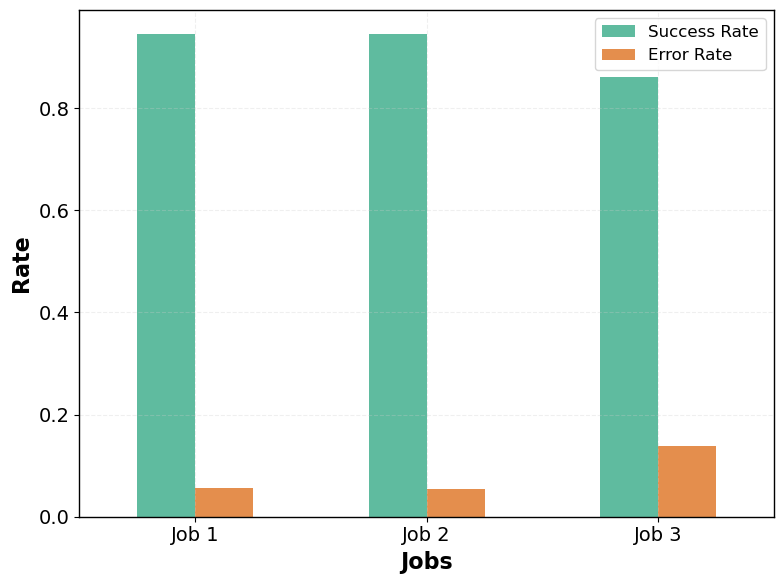

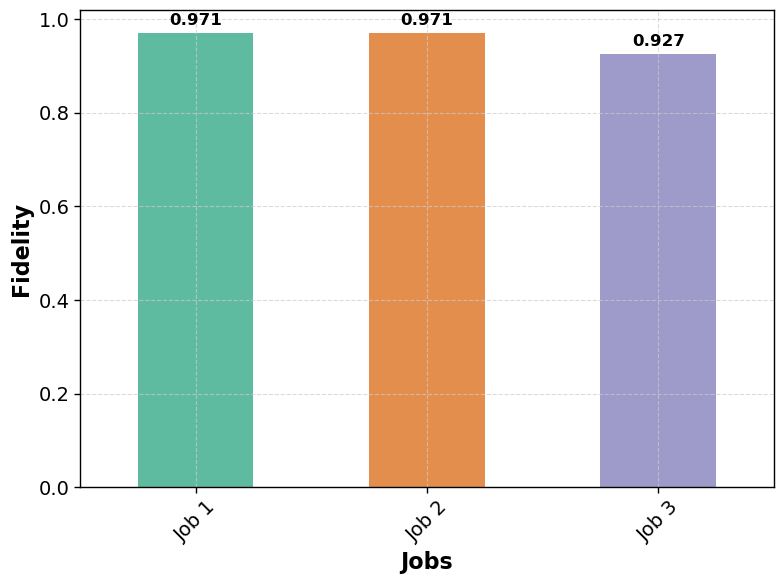

In [20]:
visualizer.generate_plots(
    selections={
        Metrics.CIRCUIT_PERFORMANCE: [
            Plots.CircuitPerformance.SUCCESS_ERROR_COMPARISON,
            Plots.CircuitPerformance.FIDELITY_COMPARISON,
        ]
    }
)